# October 28, 2022: MAX dataset differences in network measures

In [1]:
import bct
import csv
import os
import pickle
import random
import sys
from copy import deepcopy
from itertools import combinations
from os.path import join as pjoin

import networkx as nx
import numpy as np
import pandas as pd
import scipy as sp
from brainiak.isc import compute_correlation, squareform_isfc
from scipy import signal
from tqdm.notebook import tqdm
from scipy.spatial.distance import squareform

from brainiak.isc import (
    compute_summary_statistic
)
from scipy.stats import norm, permutation_test, zscore

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_dynamics')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/oct22"

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# folders
sys.path.insert(0, proj_dir)
import helpers.dataset_utils_v1 as dataset_utils
import helpers.isc_utils as isc_utils
import helpers.fc_utils as fc_utils

In [2]:
class ARGS(): pass
args = ARGS()

args.SEED = 74
np.random.seed(args.SEED)

args.LABEL_NAMES = ['FNT', 'FNS']
args.NAMES = ['Threat', 'Safe']
args.TRIAL_LEN = 14
args.TR = 1.25 #seconds
EARLY = np.arange(2.5, 8.75+args.TR, args.TR) // args.TR
LATE = np.arange(10.0, 16.25+args.TR, args.TR) // args.TR
EARLY = EARLY.astype(int)
LATE = LATE.astype(int)
args.PERIOD_TRS = {'late': LATE, 'early': EARLY}

In [3]:
args.proj_dir = proj_dir
args.roi_set_name = 'mashid'
args.main_data_dir = (
    f"{proj_dir}/data/max/neutral_runs_trial_level_FNSandFNT/{args.roi_set_name}"
)
# exploratory data
args.subjects = os.listdir(args.main_data_dir)
random.Random(args.SEED).shuffle(args.subjects)
args.explor_subjects = args.subjects[ : round(0.35 * len(args.subjects))]

# ROIs
args = dataset_utils.get_mashid_rois(args)
args = dataset_utils.get_mashid_plot_tick_labels(args)

[13 12 12  8]
[13 25 37]
[ 7 19 31 41]
['Salience' 'Executive' 'Task negative' 'Subcortical']


## dataset

In [4]:
X = dataset_utils.get_max_trial_level_responses(args)
for name in X.keys():
    X[name] = [x for x in X[name] if x.shape[-1] == args.num_rois if x.shape[0] > 11]
    for idx_subj in range(len(X[name])):
        X[name][idx_subj] = X[name][idx_subj][:, :, args.roi_idxs]

# args.plot_colors = {'Threat': 'firebrick', 'Safe': 'cornflowerblue'}
# dataset_utils.plot_max_responses(args, X)

  0%|          | 0/38 [00:00<?, ?it/s]

In [5]:
# subject-wise responses at each TR
ts = dataset_utils.get_max_block_time_series(args, X,)
args.blocks = list(ts.keys())

## ISC

100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


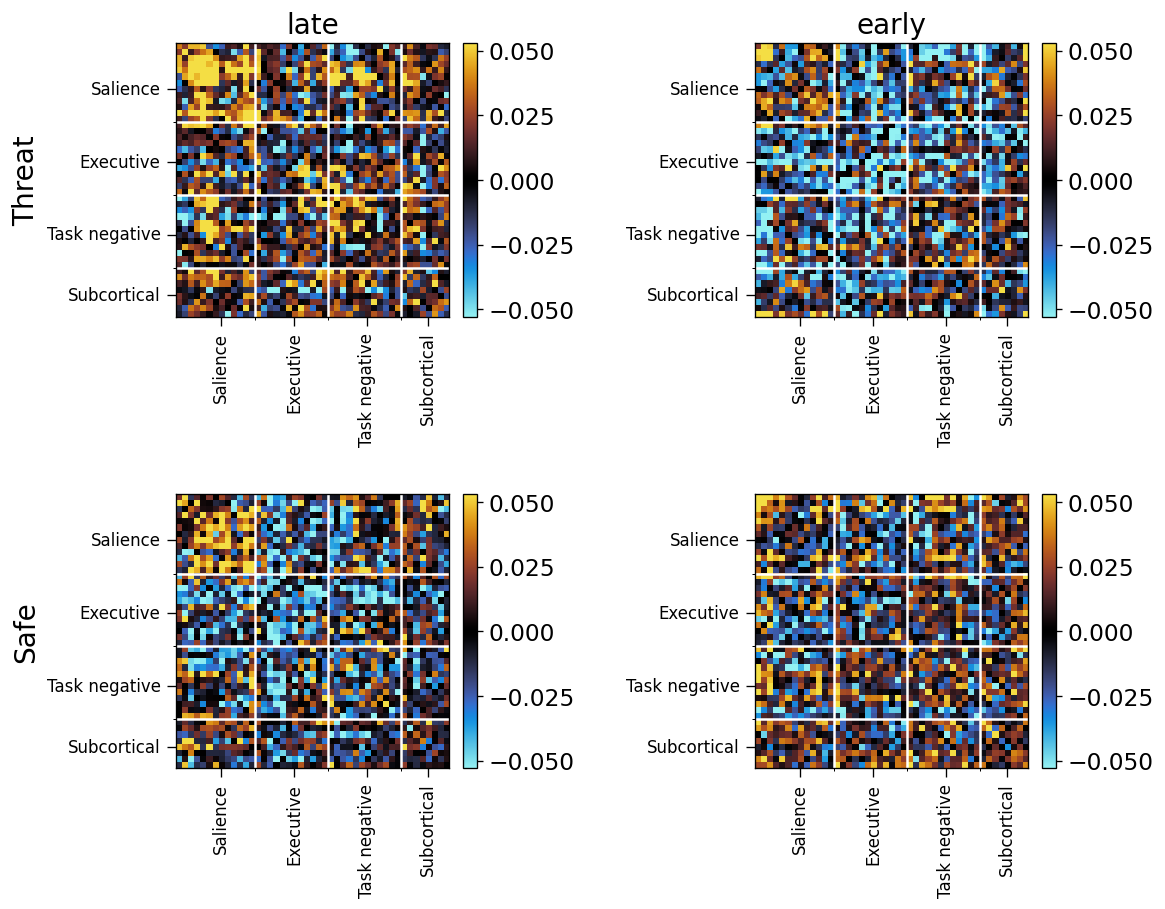

In [6]:
# ISC matrices for both periods (early/late) and 
# both emotional conditions (threat/safe)
args.CORR_NAMES = ['isfcs', 'iscs']
args.pairwise=False
args.vectorize_isfcs = True
args.n_bootstraps = 1000
args.positive_only = False
(
    corrs, 
    bootstraps, 
    rois
) = isc_utils.get_isfcs(
    args, 
    ts
)
(
    observed_isfcs, observed_p_vals, 
    significant_rois, conf_intervals
) = isc_utils.get_squareform_matrices(
    args, 
    bootstraps, 
    rois,
    threshold_mats=False
)
isc_utils.plot_max_isfcs(
    args, 
    observed_isfcs, 
    significant_rois
)

6it [00:18,  3.14s/it]


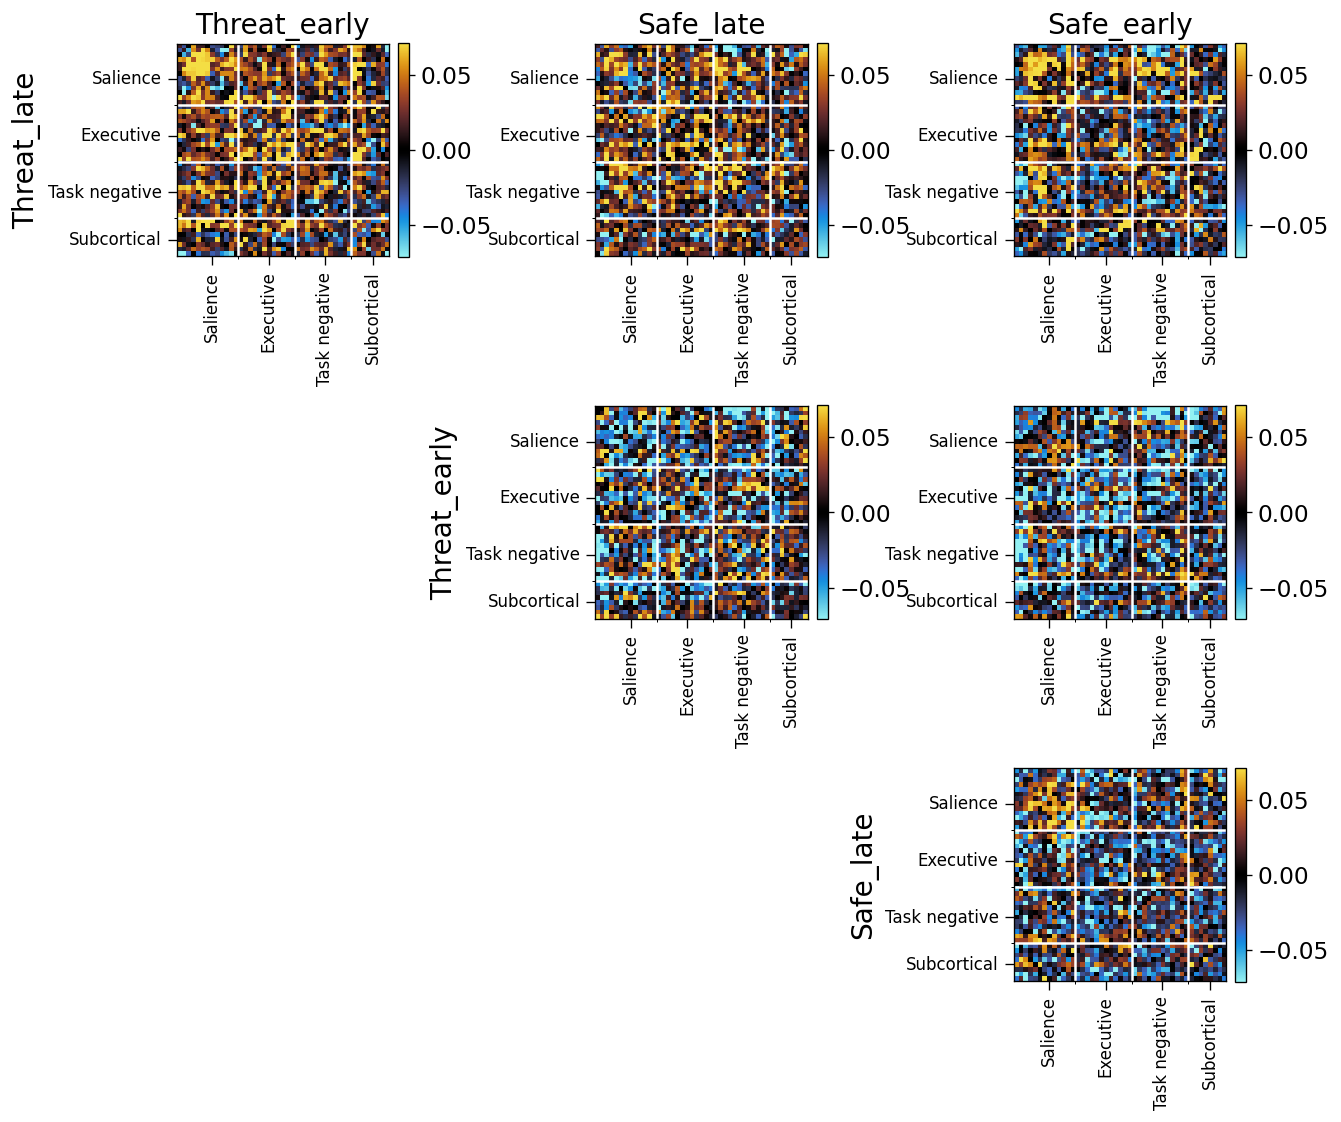

In [7]:
# difference ISCs
stats_results = isc_utils.get_comparison_stats(
    args, 
    corrs,
    paradigm='max',
    how_pairs='all_combs',
)
(
    diff_isfcs, 
    diff_pvals
) = isc_utils.get_diff_isfcs(
    args, 
    stats_results, 
    significant_rois, 
    threshold_mats=False
)
isc_utils.plot_isfc_comparisons(
    args, 
    corrs, 
    diff_isfcs, 
    paradigm='max'
)

In [8]:
# bootstrap ISCs
(
    bootstrap_isfcs, 
    all_isfcs
) = isc_utils.get_bootstrap_distribution_isfcs(
    args, 
    observed_isfcs, 
    bootstraps,
)

In [9]:
# separate positive and negative weights
(
    all_isfcs_pos, all_isfcs_neg,
    all_sq_isfcs_pos, all_sq_isfcs_neg
) = isc_utils.separate_pos_neg_weights(
    args, 
    all_isfcs, 
    significant_rois
)

## Network analysis

In [10]:
sq_corrs = {}
for block in corrs.keys():
    sq_corrs[block] = squareform_isfc(corrs[block]['isfcs'], corrs[block]['iscs'])

In [11]:
args.plot_blocks = ['Tl', 'Te', 'Sl', 'Se']

### network measures

In [12]:
def paired_permutation_test(args, obs1, obs2, measure_name='global_efficiency', alternative='two-sided'):
    n_resamples = args.n_bootstraps // 5
    n_samples = obs1.shape[0]
    all_samples = np.stack([obs1,obs2],axis=0)

    def gen_shuffled_groups():
        idx_grp1 = np.random.randint(2, size=n_samples)
        group1 = [all_samples[grp,i,:,:] for i,grp in enumerate(idx_grp1)]
        group1 = np.stack(group1,axis=0)
        
        idx_grp2 = 1 - idx_grp1
        group2 = [all_samples[grp,i,:,:] for i,grp in enumerate(idx_grp2)]
        group2 = np.stack(group2,axis=0)

        return group1, group2

    def statistic(args, obs1, obs2, axis=0, measure_name='global_efficiency'):
        mat1 = compute_summary_statistic(obs1, summary_statistic='median', axis=axis)
        mat2 = compute_summary_statistic(obs2, summary_statistic='median', axis=axis)

        if measure_name == 'global_efficiency':
            m1 = bct.distance.efficiency_wei(mat1, local=False)
            m2 = bct.distance.efficiency_wei(mat2, local=False)

        elif measure_name == 'local_efficiency':
            m1 = bct.distance.efficiency_wei(mat1, local=True)
            m2 = bct.distance.efficiency_wei(mat2, local=True)
            
            c1, c2 = [], []
            for idx_nw, (nw, nw_idxs) in enumerate(args.nw_roi_idxs.items()):
                c1 += [np.mean(m1[nw_idxs])]
                c2 += [np.mean(m2[nw_idxs])]
            m1, m2 = np.stack(c1), np.stack(c2)

        elif measure_name == 'betweenness':
            m1 = bct.centrality.betweenness_wei(mat1)
            m2 = bct.centrality.betweenness_wei(mat2)

            c1, c2 = [], []
            for idx_nw, (nw, nw_idxs) in enumerate(args.nw_roi_idxs.items()):
                c1 += [np.mean(m1[nw_idxs])]
                c2 += [np.mean(m2[nw_idxs])]
            m1, m2 = np.stack(c1), np.stack(c2)

        elif measure_name == 'modularity':
            m1 = bct.modularity.modularity_und(mat1, kci=args.roi_nw_to_idx)
            m2 = bct.modularity.modularity_und(mat2, kci=args.roi_nw_to_idx)

        return m1 - m2

    # true
    true_statistic = statistic(args, obs1, obs2, measure_name=measure_name)

    # null
    null_statistic = []
    for idx_resample in tqdm(range(n_resamples)):
        shuffled_obs1, shuffled_obs2 = gen_shuffled_groups()
        val = statistic(args, shuffled_obs1, shuffled_obs2, measure_name=measure_name)
        null_statistic += [val]
    null_statistic = np.stack(null_statistic, axis=0)

    # pvalue
    adjustment = 1
    def less(null_statistic, observed):
        cmps = null_statistic <= observed
        pvalues = (cmps.sum(axis=0) + adjustment) / (n_resamples + adjustment)
        return pvalues

    def greater(null_statistic, observed):
        cmps = null_statistic >= observed
        pvalues = (cmps.sum(axis=0) + adjustment) / (n_resamples + adjustment)
        return pvalues

    def two_sided(null_statistic, observed):
        pvalues_less = less(null_statistic, observed)
        pvalues_greater = greater(null_statistic, observed)
        pvalues = np.minimum(pvalues_less, pvalues_greater) * 2
        return pvalues

    compare = {"less": less,
               "greater": greater,
               "two-sided": two_sided}

    pvalues = compare[alternative](null_statistic, true_statistic)
    pvalues = np.clip(pvalues, 0, 1)
    
    return true_statistic, null_statistic, pvalues

In [13]:
block1, block2 = 'Threat_late', 'Safe_late'
obs1 = sq_corrs[block1]
obs2 = sq_corrs[block2]

nw_measures = {}
for measure_name in ['local_efficiency', 'betweenness']:
    true_statistic, null_statistic, pvalues = paired_permutation_test(
        args,
        obs1, 
        obs2, 
        measure_name=measure_name
    )

    nw_measures[measure_name] = (true_statistic, null_statistic, pvalues)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [14]:
def plot_network_measures(args, nw_measures, measure_name):
    measure = nw_measures[measure_name]

    nrows, ncols = measure[0].shape[0], 1
    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols,
        figsize=(10*ncols, 4*nrows),
        dpi=120
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=None, hspace=0.4
    )

    for idx_nw, nw in enumerate(args.nw_roi_idxs.keys()):
        ax = axs[idx_nw]

        # null 
        sns.histplot(
            x=measure[1][:, idx_nw],
            kde=True,
            stat='count',
            bins=25,
            ax=ax,
            color=args.plot_colors['null_statistic'],
            linewidth=1.5,
            line_kws={'linewidth':3},
            pthresh=measure[2][idx_nw],
            label='null'
        )

        # true
        ax.axvline(
            measure[0][idx_nw], 
            color=args.plot_colors['true_statistic'], 
            linewidth=3,
            label='true'
        )

        # pvalue
        ax.text(
            0.01, 0.8,
            s=f"pval={measure[2][idx_nw]:.3f}",
            color=args.plot_colors['pvalue'][int(measure[2][idx_nw] < 0.05)],
            transform=ax.transAxes
        )

        ax.set_title(nw)
        ax.set_xlabel(measure_name)
        ax.set_ylabel(f'bin count')
        ax.legend()


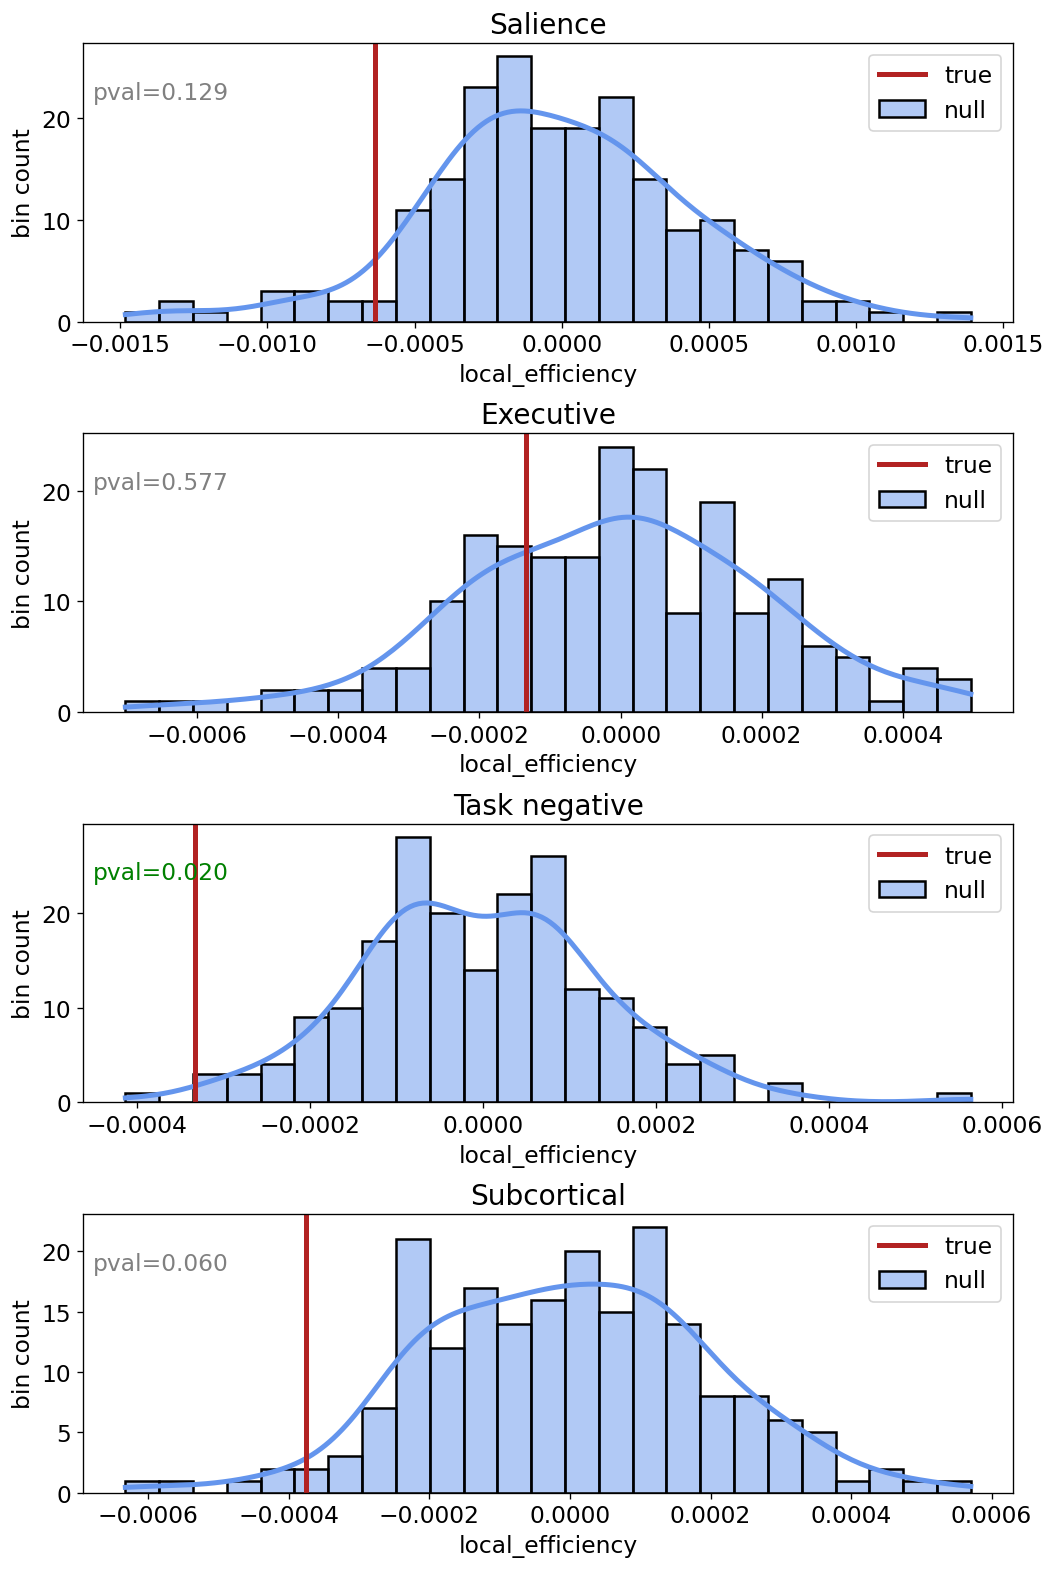

In [15]:
args.plot_colors = {
    'true_statistic': 'firebrick',
    'null_statistic': 'cornflowerblue',
    'pvalue': ['grey', 'green'],
}
plot_network_measures(
    args, nw_measures, 'local_efficiency'
)

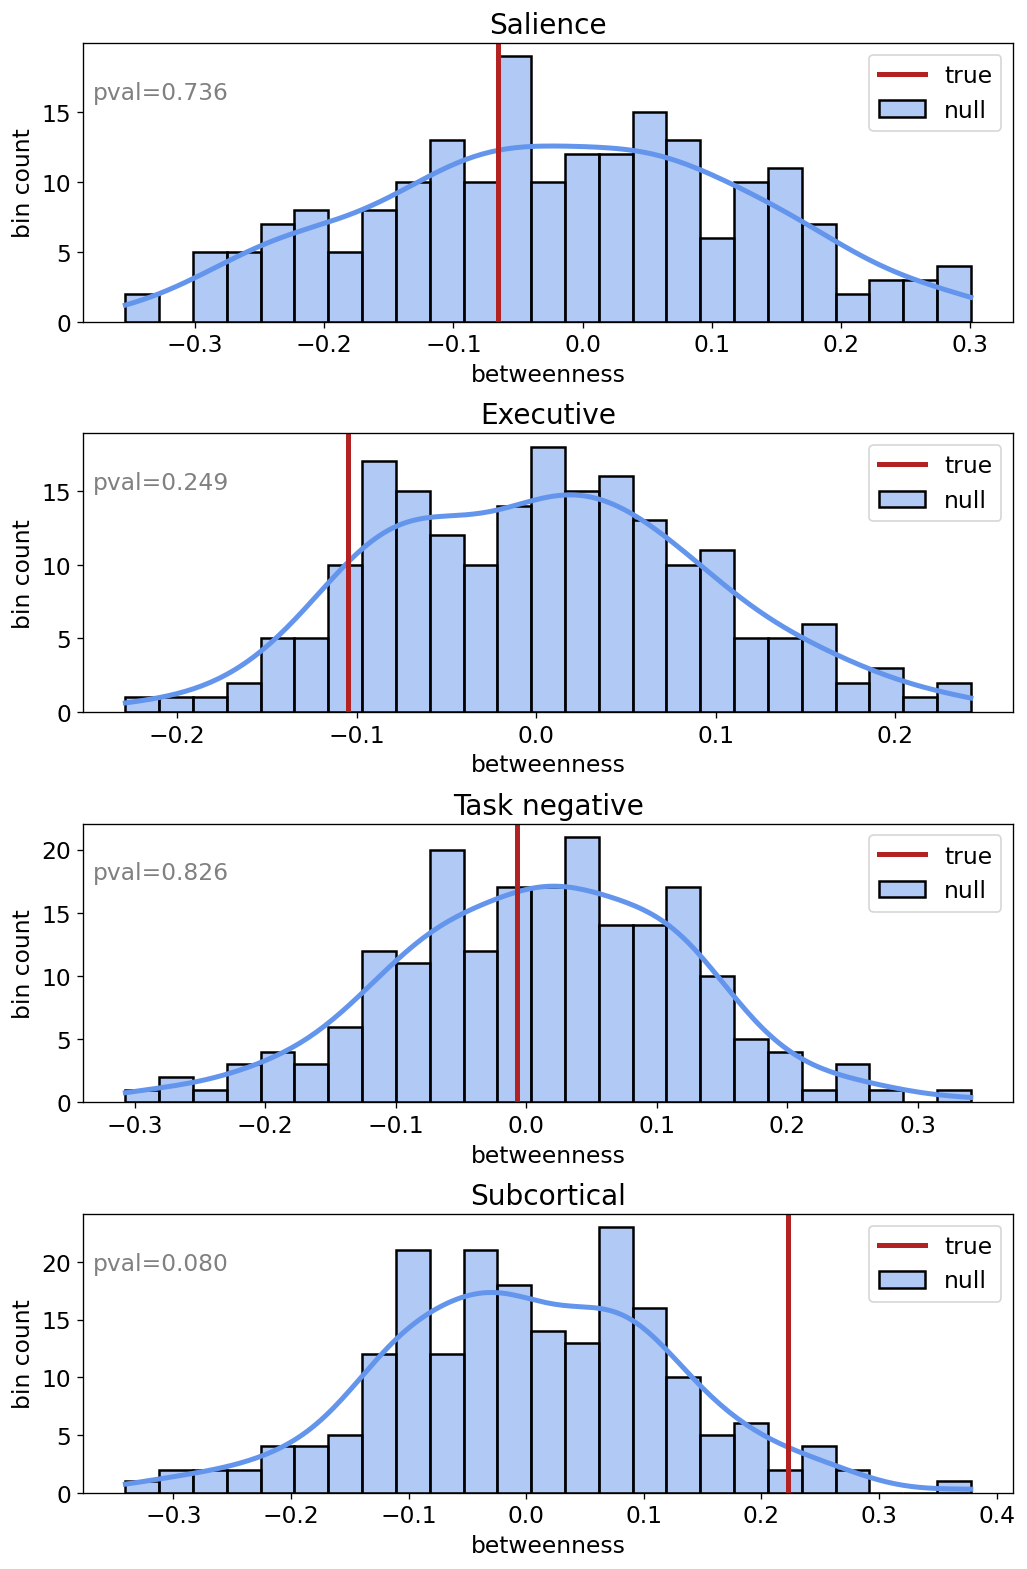

In [16]:
plot_network_measures(
    args, nw_measures, 'betweenness'
)